In [1]:
#!/usr/bin/env python
# coding: utf-8


import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import sys
import pynbody
import healpy as hp
from healpy.newvisufunc import projview, newprojplot

sys.path.append("/mnt/home/ecunningham/python")
plt.style.use('~/matplotlib.mplstyle')
import gizmo_analysis as ga
import halo_analysis as halo
import nba

# 
import pynbody_routines  as pr 
import FIRE_analysis as fa
import plotting as pl

In [2]:
def mollweide_projection(l, b, l2, b2, title, bmin, bmax, nside, smooth, **kwargs):

    """
    Makes mollweide plot using healpix
    Parameters:
    ----------- 
    l : numpy.array
    b : numpy.array
    """
 
    times = '/mnt/ceph/users/firesims/fire2/metaldiff/{}_res7100/snapshot_times.txt'.format('m12b')

    mwlmc_indices = hp.ang2pix(nside, (90-b)*np.pi/180., l*np.pi/180.)
    npix = hp.nside2npix(nside)
 
    idx, counts = np.unique(mwlmc_indices, return_counts=True)
    degsq = hp.nside2pixarea(nside, degrees=True)
    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts/degsq
    map_smooth1 = hp.smoothing(hpx_map, fwhm=smooth*np.pi/180)

    
  
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    plt.close()
    projview(
      map_smooth1,
      coord=["G"],
      graticule=True,
      graticule_labels=True,
      rot=(0, 0, 0),
      unit=" ",
      xlabel="Galactic Longitude (l) ",
      ylabel="Galactic Latitude (b)",
      cb_orientation="horizontal",
      min=bmin,
      max=bmax,
      latitude_grid_spacing=45,
      projection_type="mollweide",
      title=title,)

    newprojplot(theta=np.radians(90-(b2)), phi=np.radians(l2), marker="*", color="k", markersize=10)
    #newprojplot(theta=np.radians(90-(b2[0])), phi=np.radians(l2[0]-120), marker="*", color="r", markersize=5 )
    #newprojplot(theta=np.radians(90-(b2[1])), phi=np.radians(l2[1]-120), marker="*", color="w", markersize=2 )
    
    if 'figname' in kwargs.keys():
        print("* Saving figure in ", kwargs['figname'])
        plt.savefig(kwargs['figname'], bbox_inches='tight')
        plt.close()
    return 0

In [3]:
snap_init = 300
snap_final = 470

sim='m12b'
figname = "test_projections"


# Halo catalogue

sim_directory = "/mnt/ceph/users/firesims/fire2/metaldiff/{}_res7100/".format(sim)
m12b_subhalos = halo.io.IO.read_catalogs('snapshot', 300, sim_directory)
# Tree
halt = halo.io.IO.read_tree(simulation_directory=sim_directory)

#p0 = ga.io.Read.read_snapshots(['dark', 'star'], 'snapshot', 385, sim_directory, 
#                              assign_hosts=True, particle_subsample_factor=1)

subs_path = '/mnt/home/ecunningham/ceph/latte/m12b_res7100/massive_stream/dm_inds.npy'
subs_ids = np.load(subs_path)                                     
# load particle data



# in utilities.simulation.Snapshot():
* reading:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/snapshot_times.txt

  using snapshot index = 300, redshift = 0.864


# in halo_analysis.halo_io.IO():
* read 51054 halos from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/halo/rockstar_dm/catalog_hdf5/halo_300.hdf5

# in halo_analysis.halo_io.Particle():
* read 51054 halos, 96 have star particles, from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/halo/rockstar_dm/catalog_hdf5/star_300.hdf5
* assigning primary host and coordinates wrt it to halo catalog...  finished


# in utilities.simulation.Snapshot():
* reading:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/snapshot_times.txt

* read 19882039 halos from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/halo/rockstar_dm/catalog_hdf5/tree.hdf5



In [5]:
p = ga.io.Read.read_snapshots(['dark', 'star'], 'snapshot', snap_init, sim_directory, 
                          assign_hosts=True, particle_subsample_factor=1, sort_dark_by_id=True)

# Removing subhalo particles
npart = len(p['dark'].prop('mass'))
mask_sub=np.ones(npart, dtype=bool)
mask_sub[subs_ids]=0            
# Make pynbody halo
hfaceon = pr.pynbody_halo(p, mask_sub)
hsideon = pr.pynbody_halo(p, mask_sub)
pynbody.analysis.angmom.faceon(hfaceon, cen=(0,0,0))
pynbody.analysis.angmom.sideon(hsideon, cen=(0,0,0))


#subhalos

hsub = pr.pynbody_subhalos(m12b_subhalos)
hsub_faceon = pr.pynbody_subhalos(m12b_subhalos)

# Satellite orbit
sat_id = np.argsort(hsub.dark['mass'])[-2]
sat_tree_id = m12b_subhalos['tree.index'][sat_id]
satellite = fa.return_tracked_pos(halt, sat_tree_id, pynbody_halo=True)
satellite_faceon = satellite


h_rotations = pr.pynbody_halo(p)
faceon, edgeon = pr.make_pynbody_rotations(h_rotations)

pynbody.transformation.transform(hsub_faceon, faceon)

pynbody.transformation.transform(satellite_faceon, faceon)

#multipanel_plot(hfaceon, hsideon, satellite_faceon, k, figname)

pos_dm = hfaceon.dark['pos']
f = 1* (u.km/u.s).to(u.kpc/u.Gyr)
vel_dm = hfaceon.dark['vel']*f
dist_dm = np.sqrt(np.sum(pos_dm**2, axis=1))
dist_cut = np.where((dist_dm> 50) & (dist_dm< 300)) 
dm_kinematics = nba.kinematics.Kinematics(pos_dm[dist_cut],  vel_dm[dist_cut])
dm_OP_l_host, dm_OP_b_host = dm_kinematics.orbpole()


sat_kinematics = nba.kinematics.Kinematics(satellite_faceon.dark['pos'],  satellite_faceon.dark['vel'])
sat_l_host, sat_b_host = sat_kinematics.pos_cartesian_to_galactic()
sat_OP_l_host, sat_OP_b_host = sat_kinematics.orbpole()

times = '/mnt/ceph/users/firesims/fire2/metaldiff/{}_res7100/snapshot_times.txt'.format('m12b')
t_snap = np.loadtxt(times, usecols=3)




# in utilities.simulation.Snapshot():
* reading:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/snapshot_times.txt

  using snapshot index = 300, redshift = 0.864


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/output/snapdir_300/snapshot_300.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 74537000 particles
    dark2     (id = 2): 6750970 particles
    gas       (id = 0): 66706907 particles
    star      (id = 4): 8052512 particles
    blackhole (id = 5): 0 particles

* reading species: ['dark', 'star']
* reading particles from:
    snapshot_300.0.hdf5
    snapshot_300.1.hdf5
    snapshot_300.2.hdf5
    snapshot_300.3.hdf5
    snapshot_300.4.hdf5
    snapshot_300.5.hdf5
    snapshot_300.6.hdf5
    snapshot_300.7.hdf5

* reading cosmological parameters from:  mnt/ceph/users/firesims/fire2/metaldiff/m12b_res7100/initial_condition/ic_agora_m12b.conf

* sorting the following d

/mnt/home/nico/.local/lib/python3.8/site-packages/nba/kinematics/kinematics.py:132: RuntimeWarning: invalid value encountered in true_divide
  u = uu.T/uumag


0

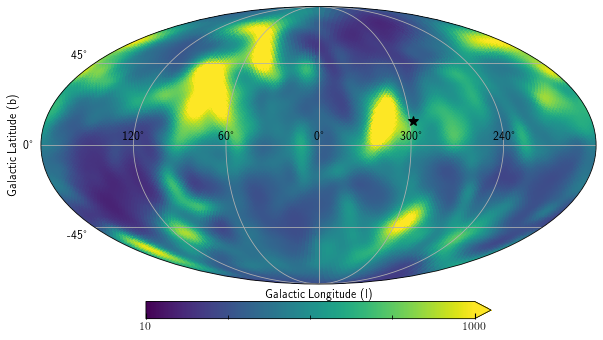

In [9]:
mollweide_projection(dm_OP_l_host, dm_OP_b_host, sat_OP_l_host[300-300], sat_OP_b_host[300-300], 
                     title="", bmin=10, bmax=1000,
                     nside=40, smooth=8)

In [22]:
vel_shift = np.zeros_like(vel_dm[dist_cut])
vel_shift[:,2] = 60


pos_shift = np.zeros_like(pos_dm[dist_cut])
pos_shift[:,0] = 60

In [23]:
dm_kinematics_shift = nba.kinematics.Kinematics(pos_dm[dist_cut]-pos_shift,  vel_dm[dist_cut]-vel_shift)
dm_OP_l_host_shift, dm_OP_b_host_shift = dm_kinematics_shift.orbpole()

0

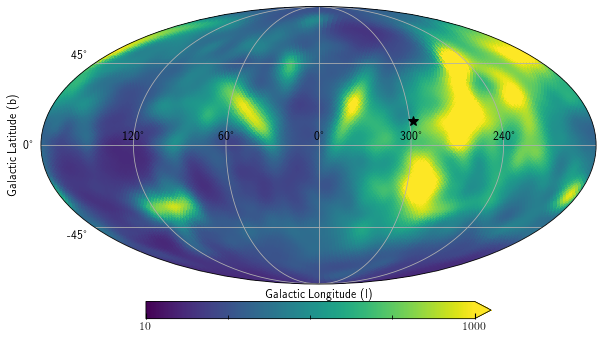

In [24]:
mollweide_projection(dm_OP_l_host_shift, dm_OP_b_host_shift, sat_OP_l_host[300-300], sat_OP_b_host[300-300], 
                     title="", bmin=10, bmax=1000,
                     nside=40, smooth=8)